# Simulation of Limonene dataset

The outline is roughly as follows:
1. Generate pathway proteomic time-series using leaky hill function (the parameters are randomized).
2. Choose kinetic model coefficients (based on values from the literature)
3. Solve the intial value problem to generate time-series of metabolite concentrations

NOTE: The hill function was chosen because it models the dynamics of protein expression from RNA accurately.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from scipy.interpolate import interp1d
import csv
import math
import numpy as np
from scipy.integrate import odeint, ode
from scipy.optimize import differential_evolution

In [2]:
# Set Output Time Points
#timePoints = [0,2,4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48]
timePoints = list(range(72)) #72Hours, to be consistent with experimental data
num_strains = 10000 #10000
num_proteins = 9
num_substrates = 10 # number of metabolites
num_parameters = 34 # number of kinetic parameters

# noise parameters
measurement_noise_percent = 0.00005
sigma = measurement_noise_percent**(0.5)

# bounds for the hill function coefficients (total 3 * num_proteins)
bounds = [(1e6,1e7),(0.1,1),(1e-10,1e1)]*num_proteins
#bounds = [(1e-10,1e1),(0.001,1),(1e-10,1e0)]*num_proteins

# lower and upper bounds for the hill coefficients
lower_bound = [bound[0] for bound in bounds]
upper_bound = [bound[1] for bound in bounds]

bounds

[(1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0),
 (1000000.0, 10000000.0),
 (0.1, 1),
 (1e-10, 10.0)]

## 1. Generate Time-series Data

We have two time-series of concentrations:
1. Proteomics (using leaky hill function)
2. Metabolomics (using standard curve)

In [3]:
def leaky_hill_fcn(t, kf, km, kl):
    """
    Leaky hill function to generate proteomics data.
    The coefficients kf, km, and kl are supposed to be chosen randomly.
    
    http://www.bio-physics.at/wiki/index.php?title=Hill_Function
    """
    
    return kf * t/(km + t) + kl

def proteomicsData(t, k):
    """
    Generate proteomics time-series data.
    """
    
    e = []
    for i in range(int(len(k)/3)):
        # sorting the gains (coefficients of the leaky hill function)
        # to ensure proteins are monotonically non-decreasing
        gains = sorted(k[3*i:3*(i+1)], reverse=True)
        gains = k[3*i:3*(i+1)]
        e.append(leaky_hill_fcn(t,*gains)) 
    return e

def kineticOde(x, t, k, num_proteins):
    """
    Modified by Kevin for bioLearningPractical.
    
    Define the ODE of the kinetic model.
    Note that it only controls the metabolites but proteins are taken as given.
    
    Arguments
    -------------------------------------------------------
    x: substrates (metabolites)
    e: enzymes (proteins)
    kr: kinetic constants
    ke: parameters to generate protein concentrations

    Returns
    -------------------------------------------------------
    A list containing the 10 metabolite derivatives
    """
    def f(e1,e2,e3,e4,e5,e6,e7,e8,e9,
               s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
               k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
               k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
               k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
        r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
        r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
        r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
        r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
        r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
        r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
        r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
        r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
        r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
        r10 = k91*e9*s9 / (k92 + s9)
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
    ke = k[:3*num_proteins] # proteomics coefficients for the leaky hill function
    kr = k[3*num_proteins:] # kinetic constants
    e = proteomicsData(t,ke)
    #print(len(e),len(x),len(kr))
    return f(*e,*x,*kr)

def applyMeasurementNoise(data,noise):
    """
    Add some noise to data
    """
    return [[value + np.random.normal(scale=abs(noise*value)) for value in line] for line in data]

In [4]:
# The kinetic model coefficients were chosen to be close to values reported in the literature while maintaining a non-trivial dynamic behavior.

# set 1
fit_kinetic_parameters = [7.51679469e+01, 6.65986265e+08, 9.96515901e+08, #ATOB Params
                          1.65236177e+02, 2.87429118e+08, 4.59767573e+08, 1.00320436e+08, #HMGS PArams
                          4.55724875e+06, 6.32539506e+06, 7.12783803e+08, 9.60680172e+07, 4.13852542e+08, #HMGR
                          3.18329880e+05, 5.52989871e+08, 2.47237593e+08,
                          7.17889114e+08, 7.50755996e+08, 1.00000000e1, 6.48850195e+08, 1.42191830e+01, 
                          3.33891377e+08, 5.85448828e+08, 4.55254785e+08, 1.01295189e+08, 2.76330022e+08, 
                          6.90161521e+08, 4.98233858e+02, 8.63101820e+07, 9.65536186e+08, 8.07997571e+08,
                          1.06576294e-04, 6.27655014e+08, 2.28120610e-1, 2.91790555e2]

# set 2
fit_kinetic_parameters = [2096.3009981450155, 7874322774.19455, 49306379427.56338, 132500.5312217570943, 20586148840.691242, 23802328389.43773, 2087040054.0574365, 4439677505.252835, 266857338.26716882, 11636187181.118937, 2830617721.9279895, 38700521939.961815, 1994251.5089258063, 13495068871.5197, 5635309295.377245, 8823936481.806189, 33150292760.489136, 51.02190165102573, 19498380183.677044, 601.2843909320609, 15921655319.058493, 43094446860.82067, 42028337180.13576, 8642163412.320396, 4525784432.95358, 39055142600.75094, 37460.65655172646, 1681760830.1612275, 25648330078.428032, 48445445838.558846, 0.006281218505564503, 10867785463.5929, 1.321769162835513, 18.343026702997715]

# set 3
# fit_kinetic_parameters = [5.27715270e+08, # GPPS Enzyme
#               4.27024131e+02, # IDI Enzyme
#               5.23121317e+08, # AcetoAcetyl-CoA
#               3.49139373e+08, # MevPP
#               1.53108505e+03, # GPP
#               5.01679469e+01, # Remaining Kinetic Parameters
#               6.65986265e+08,
#               9.96515901e+08,
#               1.65236177e+01, 2.87429118e+08, 4.59767573e+08, 1.00320436e+08, 2.55724875e+08, 6.32539506e+06,
#             7.12783803e+08, 9.60680172e+07, 4.13852542e+08, 3.18329880e+04, 5.52989871e+08, 2.47237593e+08,
#             7.17889114e+08, 7.50755996e+08, 1.00000000e-12, 6.48850195e+08, 1.42191830e+01, 3.33891377e+08,
#             5.85448828e+08, 4.55254785e+08, 1.01295189e+08, 2.76330022e+08, 6.90161521e+08, 4.98233858e+02,
#             8.63101820e+07, 9.65536186e+08, 8.07997571e+08, 1.06576294e-04, 6.27655014e+08,
#             2.28120610e-02, 2.91790555e-01]

# set 4
fit_kinetic_parameters = [ 9.10164553e+00,  6.22712687e+10,   3.48900983e+10,   1.00000000e-15,
   7.79957193e+10,   1.38167796e+10,   3.82274024e+10,   1.13356214e+02,
   7.08269701e+10,   1.08286863e+09,   8.77162801e+10,   9.89656151e+10,
   4.27751831e+01,   8.31111348e+10,   2.35091924e+10,   5.52946044e+10,
   3.01340892e+10,   9.99481504e+01,   7.05000326e+10,   6.43935536e+02,
   7.62298906e+10,   6.92298699e+10,   6.19011023e+10,   3.59345149e+09,
   1.00000000e-15,   6.52997280e+10,   1.00000000e-15,   4.79123492e+10,
   4.86855244e+10,   3.91360022e+10,   4.34574168e+01,   8.29922969e+10,
   2.10759084e-03,   1.00000000e-15]

print('Number of parameters: ',len(fit_kinetic_parameters))
print(len(fit_kinetic_parameters) == num_parameters)

Number of parameters:  34
True


In [5]:
# now generate strains using the kinetic ODE

#CSV Header for the output file
CSV = [['Strain','Time', #indexes
        'AtoB','HMGS','HMGR','MK','PMK','PMD','Idi','GPPS','LS', #9 proteins
            'Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']] # 10 metabolites

# initial conditions
# all metabolites have 0.2 initial concentrations except Limonene zero.
y0 = [0.2]*(num_substrates-1) + [0]

for strain in range(num_strains):
    
    # randomly generate coefficients for hill function
    ke = np.random.uniform(low=lower_bound, high=upper_bound).tolist()
    
    # kinetic parameters
    kr = fit_kinetic_parameters
    
    # define the ODE
    kOde = lambda x,t: kineticOde(x, t, np.append(ke, kr), num_proteins)
    
    # integrate the IVP
    sol = odeint(kOde, y0, timePoints).tolist()
    
    # append proteomics concentration to the metabolite concentrations
    for i,timePoint in enumerate(timePoints):
        e = proteomicsData(timePoint, ke)
        sol[i] = e + sol[i]
    
    # add some noise
    noisyData = applyMeasurementNoise(sol, sigma)
    
    #Add Lines to CSV
    lines = [[strain+1,timePoints[i]] + line for i,line in enumerate(noisyData)]
    CSV = CSV + lines    

AtoB


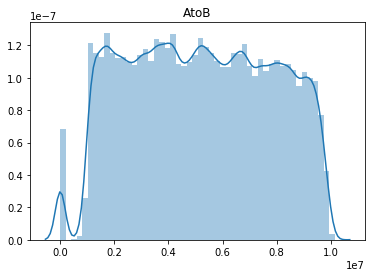

HMGS


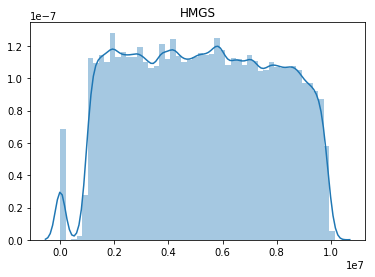

HMGR


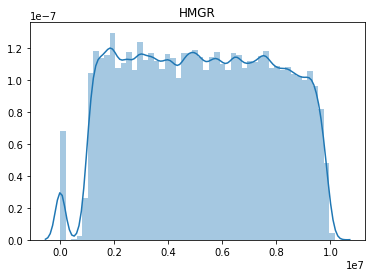

MK


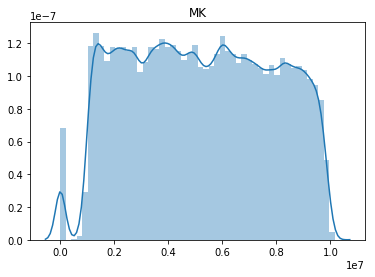

PMK


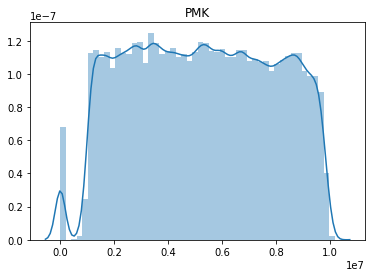

PMD


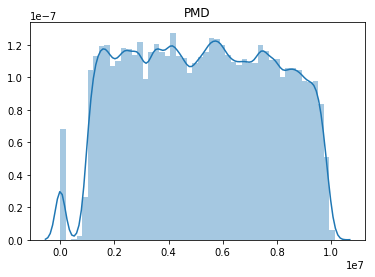

Idi


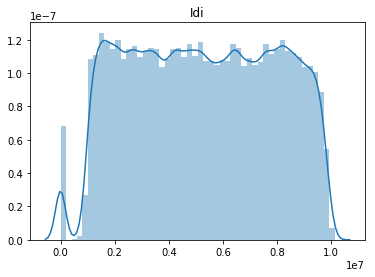

GPPS


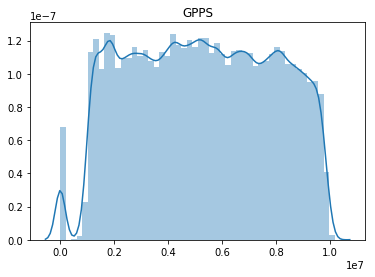

LS


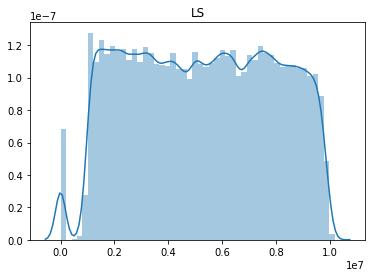

Acetyl-CoA


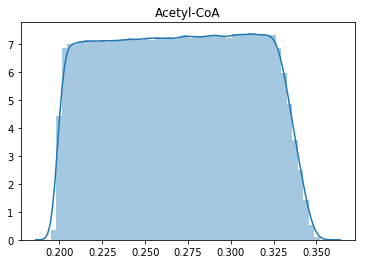

Acetoacetyl-CoA


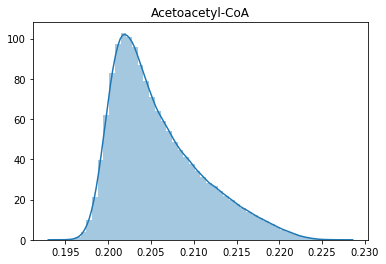

HMG-CoA


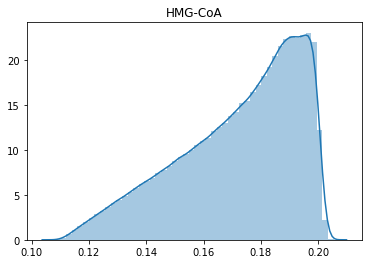

Mev


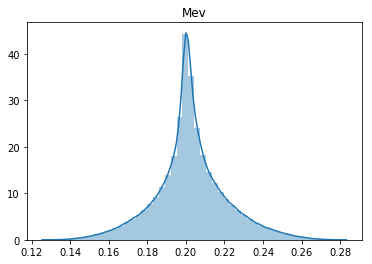

MevP


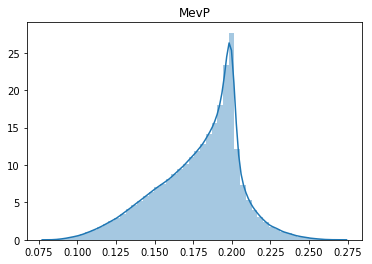

MevPP


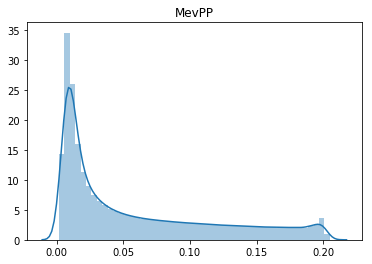

IPP


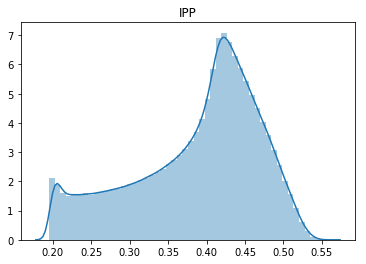

DMAPP


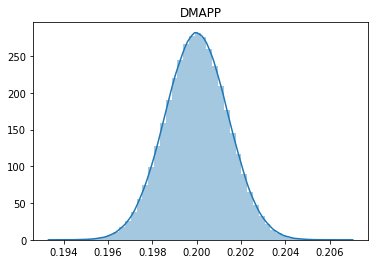

GPP


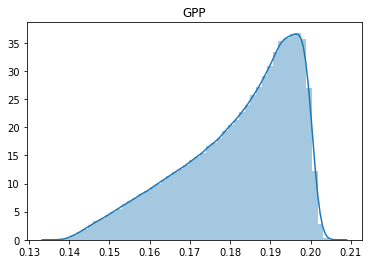

Limonene


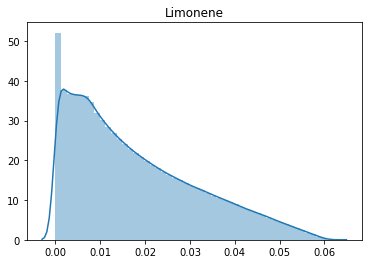

In [6]:
# Plot the density for every column

# first row is column names
df = pd.DataFrame(CSV[1:],columns=CSV[0])

column = lambda table,i: [entry[i] for entry in table[1:]]
for i in range(2,len(CSV[1])):
    print(df.columns[i])
    sns.distplot(column(CSV,i))
    plt.title(CSV[0][i])
    plt.show()

Index(['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Idi', 'GPPS', 'LS',
       'Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP',
       'IPP', 'DMAPP', 'GPP', 'Limonene'],
      dtype='object')


/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


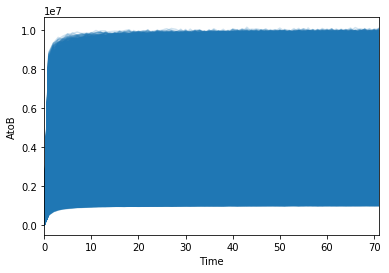

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


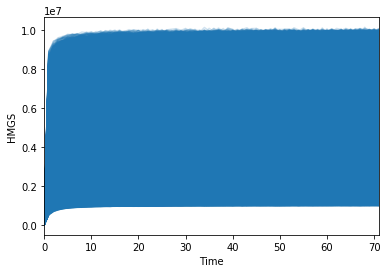

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


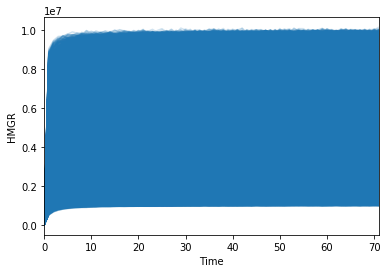

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


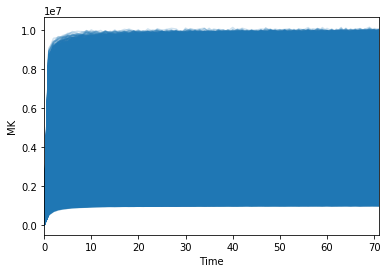

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


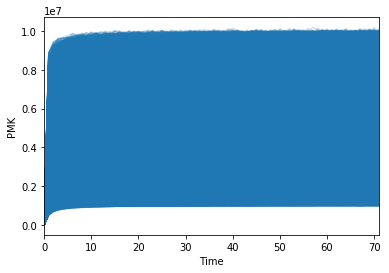

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


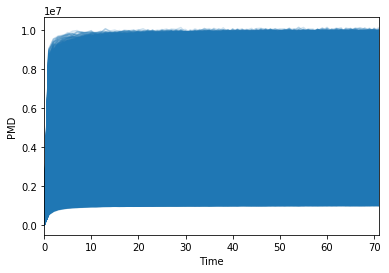

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


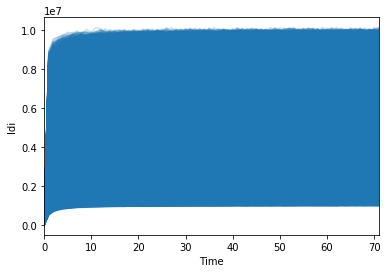

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


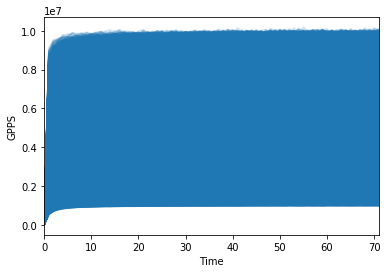

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


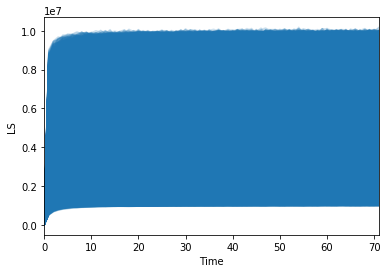

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


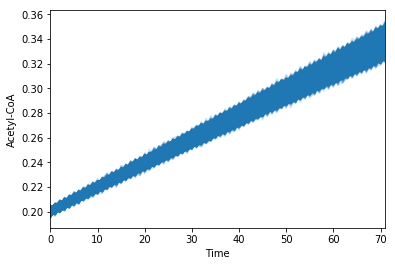

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


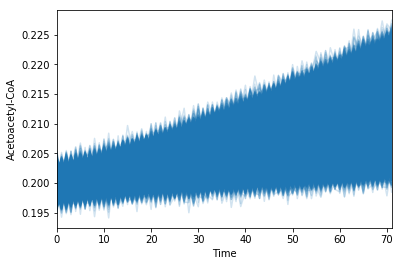

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


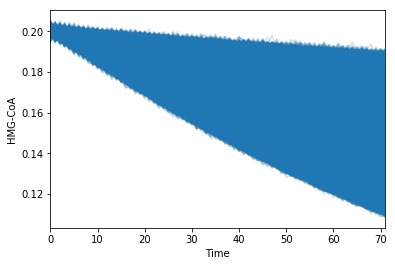

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


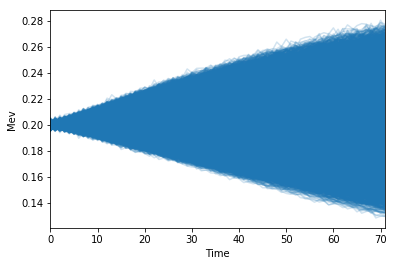

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


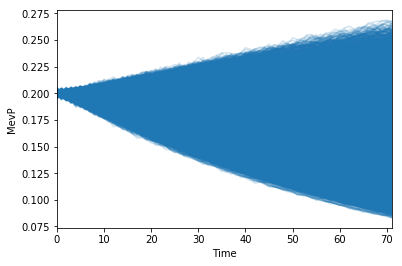

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


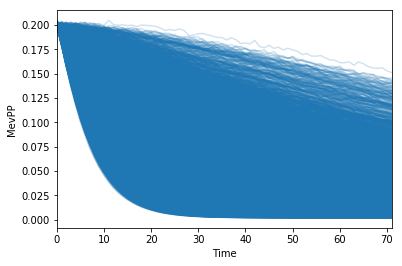

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


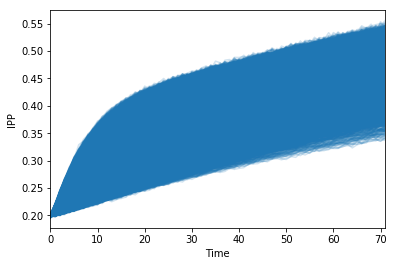

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


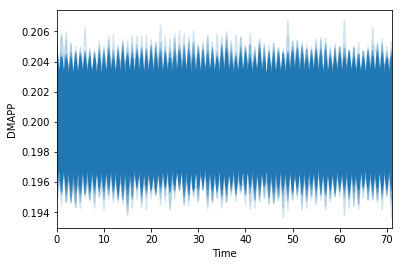

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


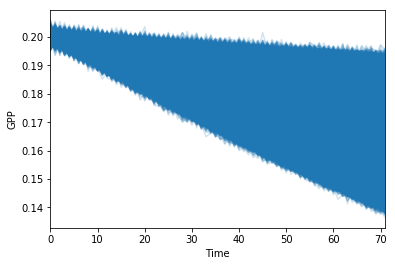

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


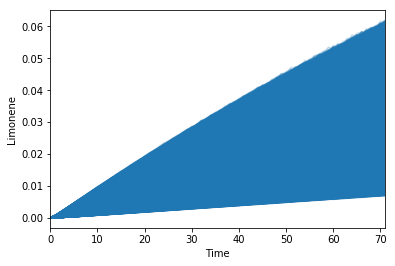

In [7]:
# trace plots
unique_strains = list(set(df['Strain'].values))
species = df.columns[2:]
print(species)
for element in species:
    #display(df[['Time','Strain',element]])
    sns.tsplot(df,time='Time',unit='Strain',value=element,err_style='unit_traces')
    plt.show()

## 2. Write simulated data to CSV

In [8]:
# write CSV to disk
fileName =  'limonene_simulated_n' + str(num_strains) + '.csv'
with open(fileName, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(CSV)

## 3. Trying out some other stuffs

In [9]:
from bioLearningPractical.integrator import odeintz

help(odeintz)

Help on function odeintz in module bioLearningPractical.integrator:

odeintz(fun, y0, times, method='dopri5', tol=0.0001)
    Modified by Kevin for bioLearningPractical.
    
    Integrate fun at `times` with initial conditions y0.
    'dopri5' Runge-Kutta 45 by Dormand-Prince
    'dop853' http://jacobwilliams.github.io/dop853/
    
    Args:
    - fun: function learned by ML to integrate (returned by mlode)
    - y0: initial values of the METABOLITES
    - times: time points
    - method: the integration method.
    
    Return: integrated values at `times`



In [10]:
# create standard curves for the metabolites
# 1. generate a few observation points, then interpolate them within the full time range.
# 2. this mimics how the experimental data are augmented.

bounds = (0,2)
num_points_range = (2,4)
standard_curves = []
for metabolite in range(10): # always 10 metabolites
    num_points = np.random.randint(num_points_range[0], high=num_points_range[-1]+1) + 2
    times = np.linspace(timePoints[0],timePoints[-1], num_points)
    concs = np.random.uniform(low=bounds[0], high=bounds[1], size=num_points)
    standard_curves.append(interp1d(times, concs, kind='cubic'))
    
standard_curves

(432, 10)
(432, 19)


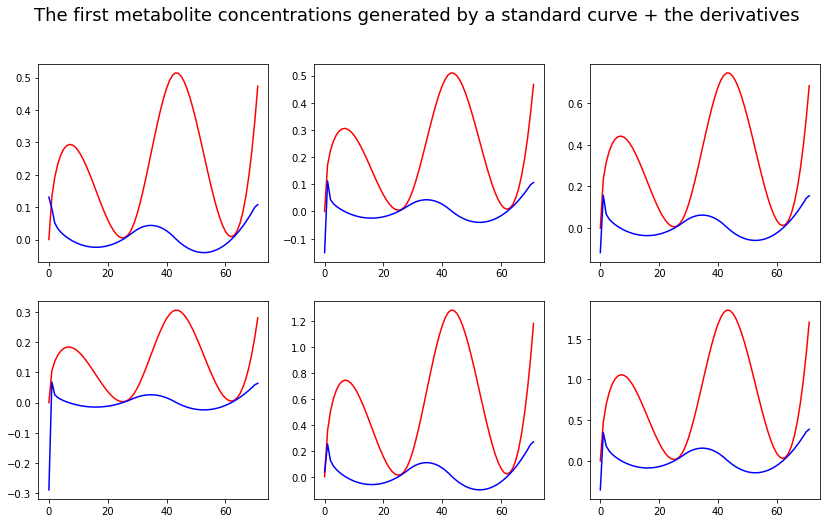

In [11]:
# generate sample strains (enzyme profiles)
# assuming 9 proteins, 10 metabolites
# plot the first metabolite concentrations generated by a standard curve and its derivatives

X = []
Y = []
dx = timePoints[1] - timePoints[0]

plt.figure(figsize=(14, 8))

for j in range(6):
    
    # generate the hill coefficients
    ke = np.random.uniform(low=lower_bound, high=upper_bound)
    #ke = [ke[i:i + 3] for i in range(0, len(ke), 3)]
    
    for t in timePoints:
        # generate protein data
        x = proteomicsData(t,ke)
 
        # generate metabolite data
        z = [(x_l + x_h)/1e7 for x_l,x_h in zip(x+[0,],[0,]+x)]
        for i,curve in enumerate(standard_curves):
            x.append(z[i]*curve(t))
        
        # create a timepoint of proteomics + metabolomics concentrations
        X.append(x)
    
    # compute the derivatives for target Y
    Y = [np.gradient(np.array(X)[:,i],1) for i in range(num_proteins,19)]
    
    plt.subplot(2, 3, j + 1)
    plt.plot(np.array(X)[j*len(timePoints):,9], 'r')
    plt.plot(Y[0][j*len(timePoints):], 'b')
    Y =  np.transpose(np.array(Y))

plt.suptitle('The first metabolite concentrations generated by a standard curve + the derivatives', fontsize=18)
print(Y.shape)            
print(np.array(X).shape)
plt.show()